# Double Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta_1 & \dot{\theta_1} & \theta_2 & \dot{\theta_2}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
torch.set_num_threads(1)
torch.set_flush_denormal(True)
import numpy as np

In [6]:
DT = 0.025  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 50 # Horizon length.
H = 3 * N  # Episode length.
U_MAX = torch.tensor([20.0])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.double_cartpole.DoubleCartpoleCost()
model = pddp.examples.double_cartpole.DoubleCartpoleDynamicsModel(DT)
env = pddp.examples.double_cartpole.DoubleCartpoleEnv(dt=DT, render=RENDER)

/usr/local/data/miniconda3/envs/pddp/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta1 = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta1_dot = X[:, 3]
    theta2 = np.unwrap(X[:, 4])  # Makes for smoother plots.
    theta2_dot = X[:, 5]
    
    plt.figure()
    plt.plot(theta1, theta1_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 1 Orientation Phase Plot")

    plt.figure()
    plt.plot(theta2, theta2_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 2 Orientation Phase Plot")
    
    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta1)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 1 orientation path")

    plt.figure()
    plt.plot(t, theta1_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 1 angular velocity path")
    
    plt.figure()
    plt.plot(t, theta2)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 2 orientation path")
    
    plt.figure()
    plt.plot(t, theta2_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 2 angular velocity path")

    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    final_state[4] = (final_state[4] + np.pi) % (2 * np.pi) - np.pi
#     print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = 1e-3 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
env.reset()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=100, tol=0,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)

/home/juancamilog/workspace/pddp/pddp/controllers/ilqr.py:374: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


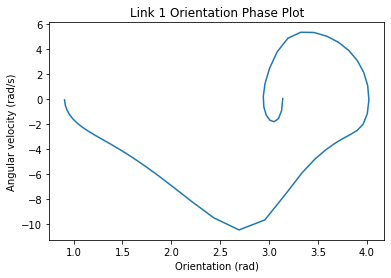

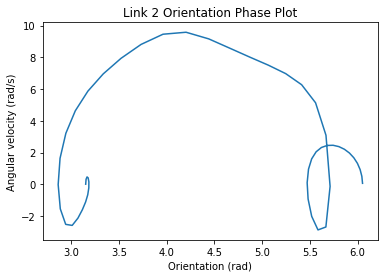

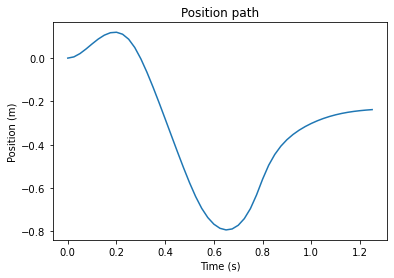

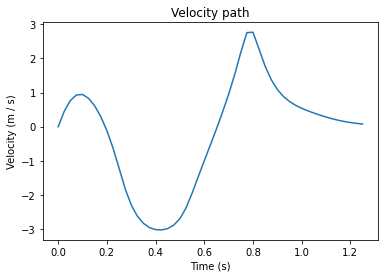

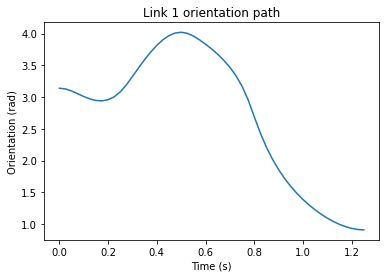

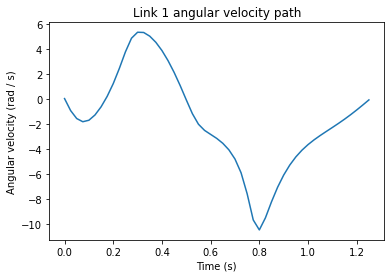

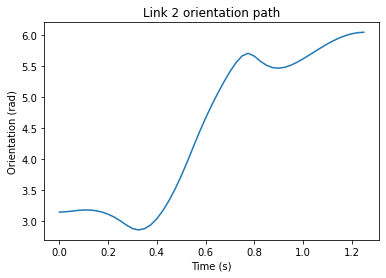

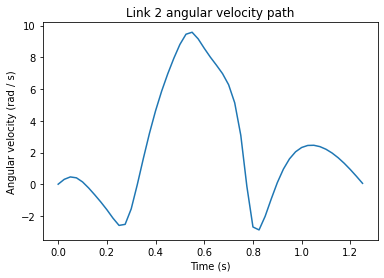

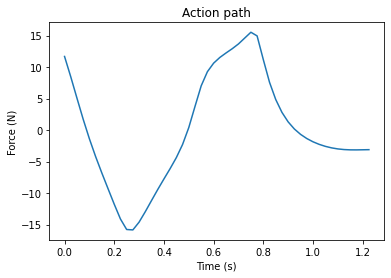

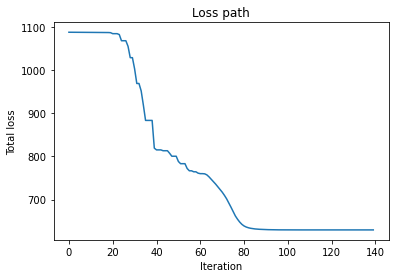

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [ ]:
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)
env.reset()

In [ ]:
plot(Z, U)

In [ ]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

In [ ]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [ ]:
env.close()